# Is a 4-d boolean function sepereable ?

In [5]:
import numpy as np

In [6]:
from tqdm import tqdm

In [7]:
import matplotlib.pyplot as plt

## load the data for the function

In [8]:
data = np.genfromtxt('data/input_data_numeric.csv', delimiter=',')

In [9]:
data.shape

(16, 5)

In [10]:
inputs = data[:,1:5].T

In [11]:
test_output = np.array( [1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1] )

## define the perceptron structure

In [12]:
from src.perceptron import Perceptron

In [13]:
activation_func = lambda x : np.tanh(x/2)

In [14]:
derivate_activation_func = lambda x :  (1-np.tanh(x/2)**2)/2

## Define energy func and grad

In [15]:
neuron = Perceptron(inputs.shape[0],activation_func,derivate_activation_func)

In [12]:
neuron.activate(inputs[:,0])

-0.11568118942924178

In [13]:
neuron.derivate(inputs[:,0])

0.49330893120611796

In [14]:
def energy_func(p,inputs,real_value):
    return (((p.activate(inputs)-real_value)**2)/2).mean()

def grad_enery(p,inputs,real_value):
    
    grad_w = 2*((p.activate(inputs)-real_value)/2)*inputs*p.derivate(inputs)
    
    grad_b = 2*((p.activate(inputs)-real_value)/2)*p.derivate(inputs)
    
    if len(grad_w.shape) > 1:
        return np.concatenate((grad_w,np.expand_dims(grad_b,axis=0))).mean(axis=1)
    else:
        return np.concatenate((grad_w,np.expand_dims(grad_b,axis=0)))

In [15]:
energy_func(neuron,inputs,test_output)

0.5667964819938351

In [16]:
grad_enery(neuron,inputs[:,0],test_output[0])

array([ 0.5503755,  0.5503755,  0.5503755,  0.5503755, -0.5503755])

In [17]:
grad_enery(neuron,inputs,test_output).shape

(5,)

## train the weights

In [18]:
def check_for_linear_separability(inputs,outputs,nb_epoch,lr,method="grad",plot=True):
    
    neuron = Perceptron(inputs.shape[0],activation_func,derivate_activation_func)
    energies = np.zeros(nb_epoch)
    
    
    for i in tqdm(range(nb_epoch)):


        #inputs_method = inputs # gradient descent
        
        if method == "grad":
            inputs_method = inputs
            outputs_method = outputs
        
        elif method == "sequential":
            index = i%inputs.shape[1]
            inputs_method = inputs[:,index]
            outputs_method = outputs[index]
            
        elif method == "sto":
            index = np.random.randint(inputs.shape[1])
            inputs_method = inputs[:,index]
            outputs_method = outputs[index]
        
        else:
            raise ValueError(f"{method} is not a method")
            
        energies[i] =energy_func(neuron,inputs_method,outputs_method)

        grad = grad_enery(neuron,inputs_method,outputs_method)

        grad_b = grad[-1]
        grad_w = grad[0:-1]

        neuron.w = neuron.w - lr*grad_w
        neuron.b = neuron.b - lr*grad_b

    
    if plot:
        plt.plot(energies)
        print(energies[-1])
    
    return (np.sign(neuron.activate(inputs)) == outputs).all()

## test on functions

In [19]:
nb_epoch=int(1e3)
lr = 0.02

In [20]:
output = np.array( [1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1] )

100%|██████████| 1000/1000 [00:00<00:00, 17519.04it/s]

4.334804517529614e-08


True

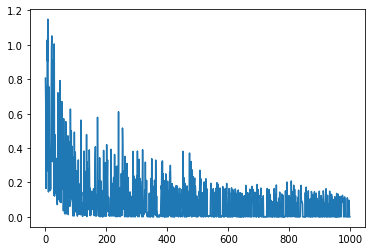

In [21]:
check_for_linear_separability(inputs,output,nb_epoch,lr=lr*inputs.shape[0],method="sto")

100%|██████████| 1000/1000 [00:00<00:00, 12573.61it/s]


0.10428084607907004


True

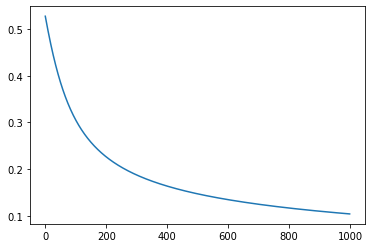

In [22]:
check_for_linear_separability(inputs,output,nb_epoch,lr,method="grad")

100%|██████████| 1000/1000 [00:00<00:00, 20635.07it/s]

0.09137690727387462


True

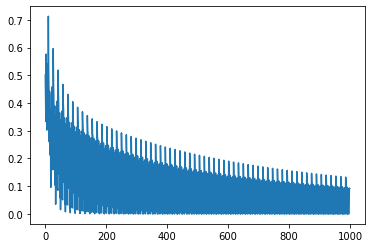

In [23]:
check_for_linear_separability(inputs,output,nb_epoch,lr=lr*inputs.shape[0],method="sequential")

# Answer the questions

In [24]:
outputs = [0,1,2,3,4,5]

In [25]:
outputs[0] = np.array(  [1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1]  )
outputs[1] = np.array([1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1] )
outputs[2] = np.array([1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1] )
outputs[3] = np.array([1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1])
outputs[4] = np.array([-1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1])
outputs[5] = np.array([-1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1])

In [26]:
nb_epoch=int(1e5)
lr = 0.02
max_tries = 10

In [27]:
for i in range(6):
        
    for _ in range(max_tries):
        is_seperable = check_for_linear_separability(inputs,outputs[i],nb_epoch,lr,method="sequential",plot=False)
        if is_seperable:
            break
    print(f"=== {i} is {is_seperable} ====")

  5%|▍         | 4905/100000 [00:00<00:03, 24622.25it/s]

=== 0 is True ====


  5%|▍         | 4865/100000 [00:00<00:03, 24295.38it/s]

=== 1 is True ====


  5%|▌         | 5167/100000 [00:00<00:03, 25794.31it/s]

=== 2 is True ====


  2%|▏         | 2286/100000 [00:00<00:04, 22858.01it/s]

=== 3 is False ====


  4%|▍         | 4374/100000 [00:00<00:04, 21709.47it/s]

=== 4 is False ====


100%|██████████| 100000/100000 [00:04<00:00, 21950.01it/s]

=== 5 is False ====
